In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from catboost import CatBoostRegressor
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV

In [4]:
df=pd.read_csv("insurance.csv")  #reading csv file

In [5]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [6]:
def check_df(dataframe, head=5):               #
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


In [7]:
check_df(df)

##################### Shape #####################
(1338, 7)
##################### Types #####################
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object
##################### Head #####################
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
##################### Tail #####################
      age     sex    bmi  children smoker     region     charges
1333   50    male  30.97         3     no  northwest  10600.5483
1334   18  female  31.92         0     no  northeast   2205.9808
1335   18  female  36.85         0     no  southeast   1629

In [8]:
#Gives the names of categorical, numerical, and categorical but cardinal variables in the data set.

def grab_col_names(dataframe, cat_th=10,  car_th=20):
    cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["category", "object", "bool"]]

    #There are variables that are categorical even though they look numeric.
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < 10 and dataframe[col].dtypes in ["int", "float"]]

    #More than 20 columns with data type "category" or "object" (categorical variables with high cardinality)
    cat_but_car = [col for col in dataframe.columns if
                   dataframe[col].nunique() > 20 and str(dataframe[col].dtypes) in ["category", "object"]]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["int", "float"]]
    num_cols = [col for col in num_cols if col not in cat_cols]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

In [9]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 1338
Variables: 7
cat_cols: 4
num_cols: 3
cat_but_car: 0
num_but_cat: 1


Categorical Variables

---



In [11]:
def cat_summary(dataframe, col_name, plot= False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=col_name, data=dataframe)
        plt.show()


        sex      Ratio
male    676  50.523169
female  662  49.476831
##########################################


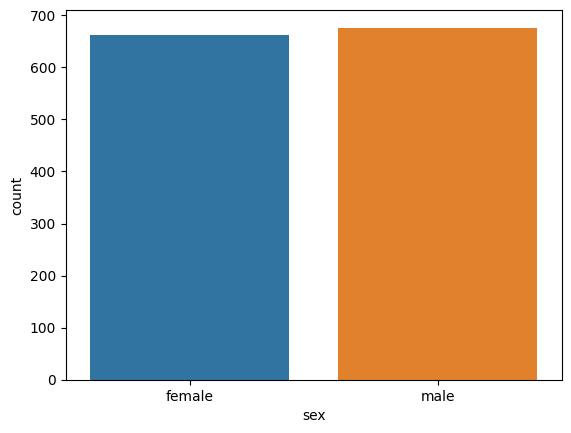

     smoker      Ratio
no     1064  79.521674
yes     274  20.478326
##########################################


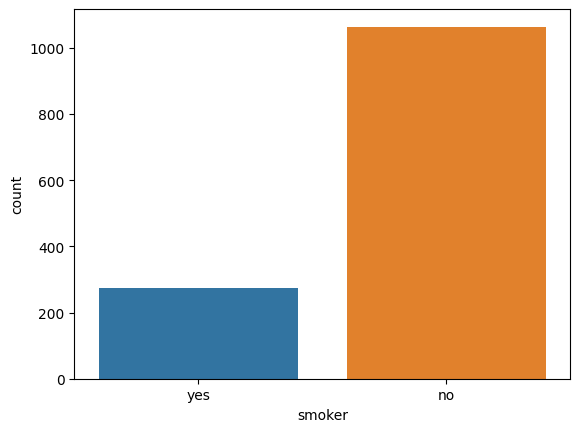

           region      Ratio
southeast     364  27.204783
southwest     325  24.289985
northwest     325  24.289985
northeast     324  24.215247
##########################################


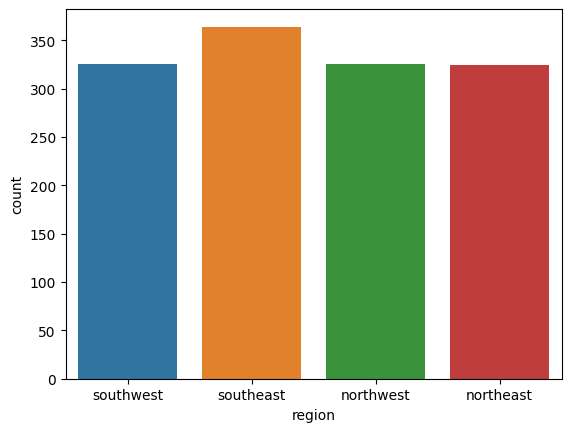

   children      Ratio
0       574  42.899851
1       324  24.215247
2       240  17.937220
3       157  11.733931
4        25   1.868460
5        18   1.345291
##########################################


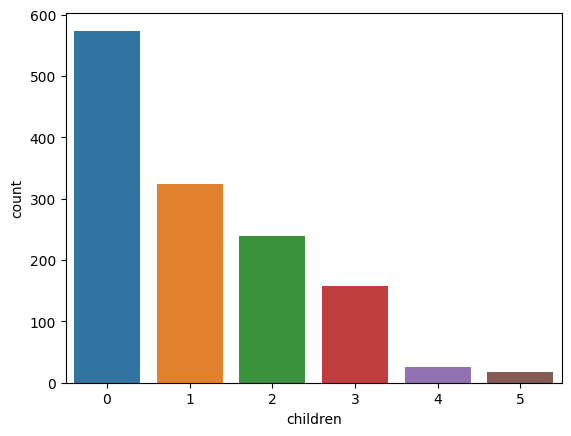

In [12]:
for col in cat_cols:
    cat_summary(df,col,plot=True)

Numeric Variables

---



In [14]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist()
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

count    1338.000000
mean       39.207025
std        14.049960
min        18.000000
5%         18.000000
10%        19.000000
20%        24.000000
30%        29.000000
40%        34.000000
50%        39.000000
60%        44.000000
70%        49.000000
80%        54.000000
90%        59.000000
95%        62.000000
99%        64.000000
max        64.000000
Name: age, dtype: float64


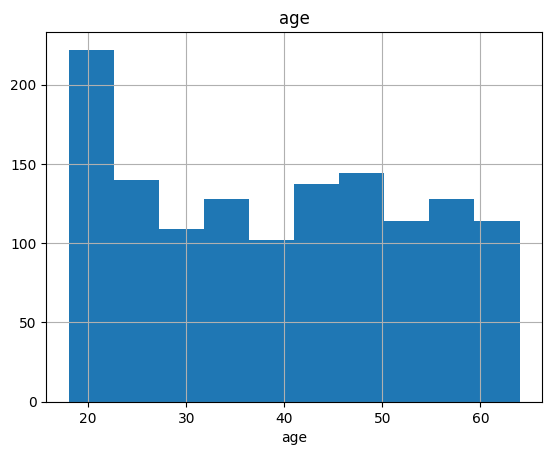

count    1338.000000
mean       30.663397
std         6.098187
min        15.960000
5%         21.256000
10%        22.990000
20%        25.326000
30%        27.360000
40%        28.797000
50%        30.400000
60%        32.032000
70%        33.660000
80%        35.860000
90%        38.619500
95%        41.106000
99%        46.407900
max        53.130000
Name: bmi, dtype: float64


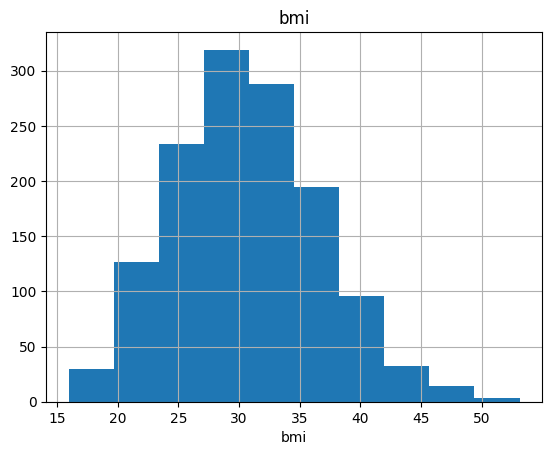

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
5%        1757.753400
10%       2346.533615
20%       3991.575720
30%       5484.846770
40%       7369.052730
50%       9382.033000
60%      11399.857160
70%      13767.875345
80%      20260.626406
90%      34831.719700
95%      41181.827787
99%      48537.480726
max      63770.428010
Name: charges, dtype: float64


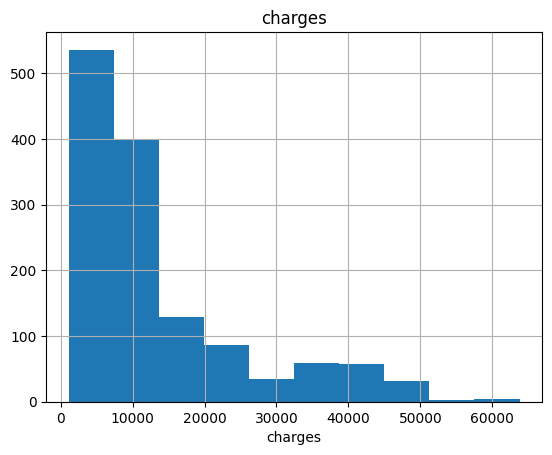

In [15]:
for col in num_cols:
  num_summary(df, col, plot=True)

Exploratory Data Analysis

---



---



-> Distribution of BMI:

In [13]:
df['bmi'].describe().T

count    1338.000000
mean       30.663397
std         6.098187
min        15.960000
25%        26.296250
50%        30.400000
75%        34.693750
max        53.130000
Name: bmi, dtype: float64

In [16]:
#for numeric
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist()
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

count    1338.000000
mean       30.663397
std         6.098187
min        15.960000
5%         21.256000
10%        22.990000
20%        25.326000
30%        27.360000
40%        28.797000
50%        30.400000
60%        32.032000
70%        33.660000
80%        35.860000
90%        38.619500
95%        41.106000
99%        46.407900
max        53.130000
Name: bmi, dtype: float64


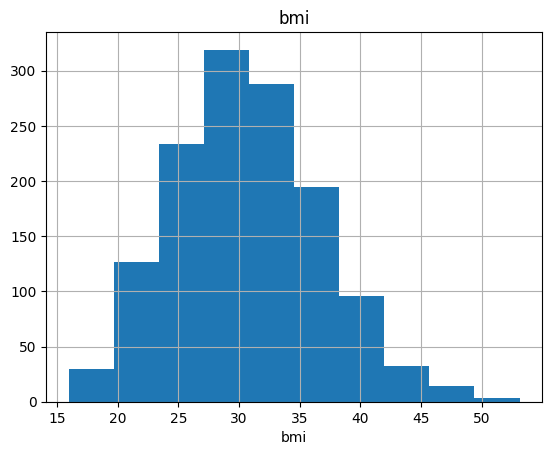

In [17]:
num_summary(df, "bmi", plot= True)

In [18]:
#In order to find outliers, we determined the lower and upper limits according to IQR.
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [19]:
#low limit and up limit
outlier_thresholds(df, "bmi")

(13.7, 47.290000000000006)

In [20]:
low, up = outlier_thresholds(df, "bmi")
#thresolds
df[(df["bmi"] < low) | (df["bmi"] > up)].index

Int64Index([116, 286, 401, 543, 847, 860, 1047, 1088, 1317], dtype='int64')

In [21]:
#check outliers/ Is there an outlier in the "bmi" variable?
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [22]:
check_outlier(df, "bmi")

True

Examining the Relationship Between Variables

---



---



-> Relationship between “smoker” and “charges”:

In [23]:
df.groupby("smoker").agg({"charges": ["mean", "median"]})

charges             
                mean       median
smoker                           
no       8434.268298   7345.40530
yes     32050.231832  34456.34845

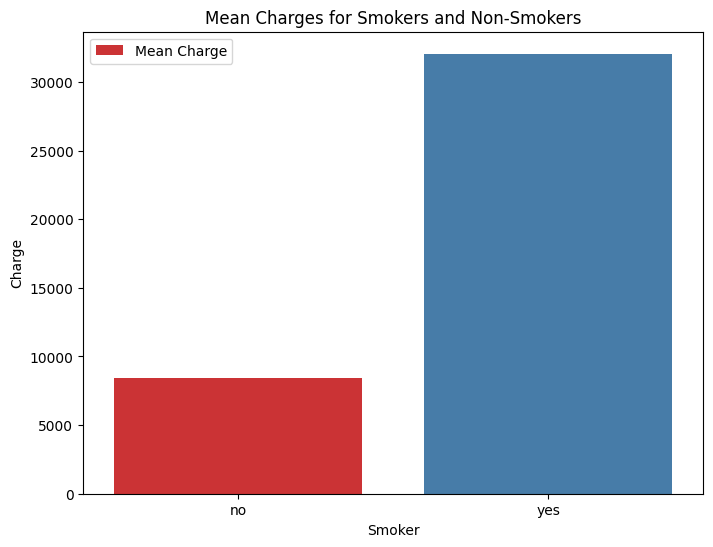

In [24]:
smoker_mean_charges = df.groupby("smoker").agg({"charges": "mean"})

#bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=smoker_mean_charges.index, y=smoker_mean_charges["charges"], palette="Set1", label="Mean Charge")
plt.title("Mean Charges for Smokers and Non-Smokers")
plt.xlabel("Smoker")
plt.ylabel("Charge")
plt.legend()
plt.show()

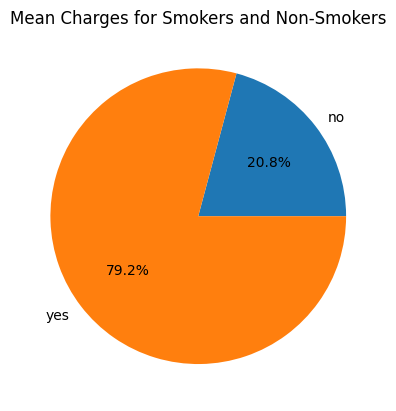

In [25]:
#pie chart
plt.pie(smoker_mean_charges["charges"], labels=smoker_mean_charges.index, autopct="%1.1f%%")
plt.title("Mean Charges for Smokers and Non-Smokers")
plt.show()

As can be seen from these two graphs, smokers have almost 4 times the cost compared to non-smokers.

-> Relationship between “smoker” and “region”:

In [26]:
df.groupby("smoker")["region"].value_counts().unstack()

region,northeast,northwest,southeast,southwest
smoker,,,,
no,257,267,273,267
yes,67,58,91,58


Text(0.5, 1.0, 'According to Region, Smokers')

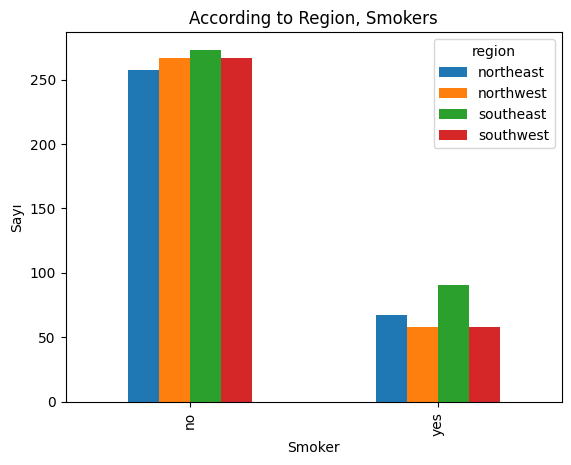

In [27]:
smoker_region=df.groupby("smoker")["region"].value_counts().unstack()
smoker_region.plot(kind="bar")
plt.xlabel("Smoker")
plt.ylabel("Sayı")
plt.title("According to Region, Smokers")

-> Relationship between “bmi” and “sex”:

In [28]:
df.groupby("sex").agg({"bmi": ["mean", "median"]})


bmi         
             mean   median
sex                       
female  30.377749  30.1075
male    30.943129  30.6875

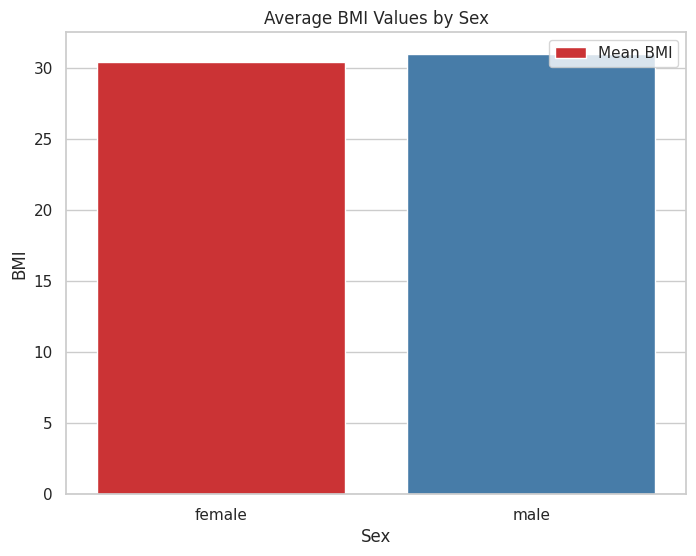

In [29]:
summary = df.groupby("sex").agg({"bmi": ["mean", "median"]})
sns.set(style="whitegrid")  # İsteğe bağlı: çizim stili ayarı
plt.figure(figsize=(8, 6))
sns.barplot(x=summary.index, y=summary[("bmi", "mean")], palette="Set1", label="Mean BMI")
plt.title("Average BMI Values by Sex")
plt.xlabel("Sex")
plt.ylabel("BMI")
plt.legend()
plt.show()

([<matplotlib.patches.Wedge at 0x7ec778e37190>,
 [Text(0.0159304664828703, 1.099884639513453, 'female'),
  Text(-0.015930466482870678, -1.099884639513453, 'male')],
 [Text(0.00868934535429289, 0.599937076098247, '49.5%'),
  Text(-0.008689345354293096, -0.599937076098247, '50.5%')])

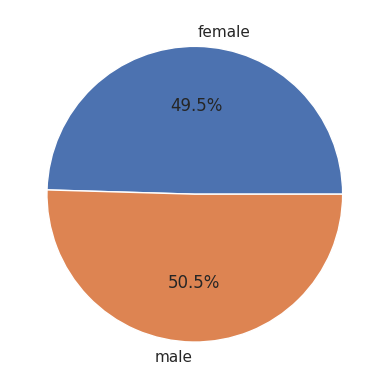

In [30]:
sex_bmi=df.groupby("sex")["bmi"].mean()
plt.pie(sex_bmi.values,labels=sex_bmi.index,autopct="%1.1f%%")

They're pretty close, but the male's bmi seem to have a little bit more.

-> According to region, children numbers:

Text(0.5, 1.0, 'According To Region, Children Numbers')

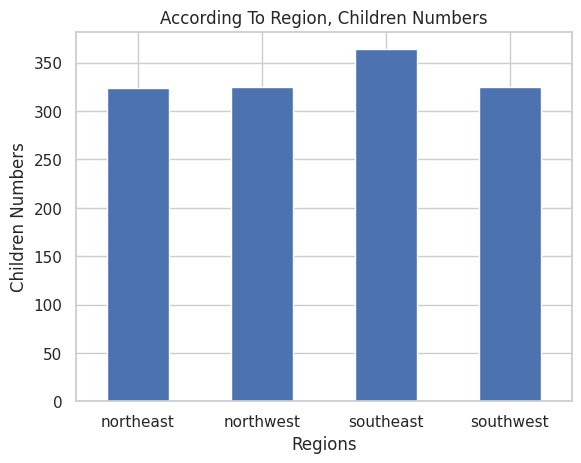

In [31]:
region_children=df.groupby("region")["children"].count()
region_children.plot(kind="bar")
plt.xticks(rotation=0)
plt.xlabel("Regions")
plt.ylabel("Children Numbers")
plt.title("According To Region, Children Numbers")

Finally,The region with the most children is southeast.

-> Relationship between “age” and “bmi”:

Text(0.5, 1.0, 'According to age, mean bmi')

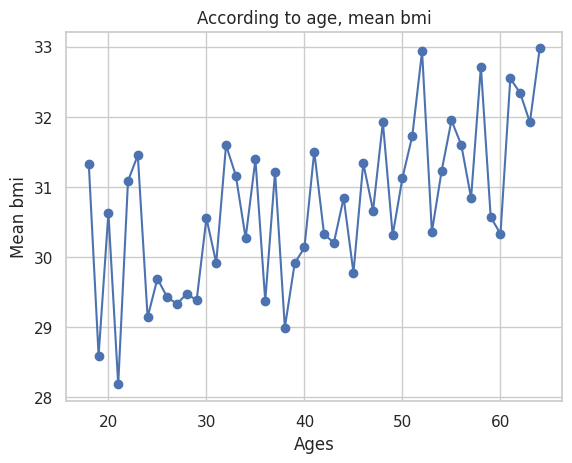

In [32]:
age_bmi=df.groupby("age")["bmi"].mean()
plt.plot(age_bmi.index, age_bmi.values, marker="o")
plt.xlabel("Ages")
plt.ylabel("Mean bmi")
plt.title("According to age, mean bmi")

We have an unstable bmi average, although we can comment on some points.

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5')])

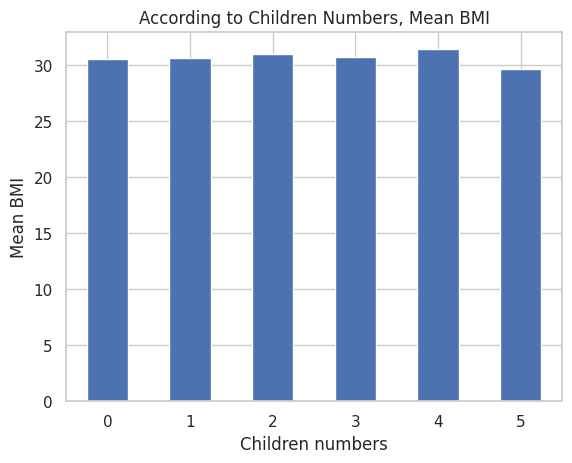

In [33]:
children_bmi=df.groupby("children")["bmi"].mean()
children_bmi.plot(kind="bar")
plt.xlabel("Children numbers")
plt.ylabel("Mean BMI")
plt.title("According to Children Numbers, Mean BMI")
plt.xticks(rotation=0)

BMI averages do not vary much depending on the number of children. If we want to examine it in more detail:

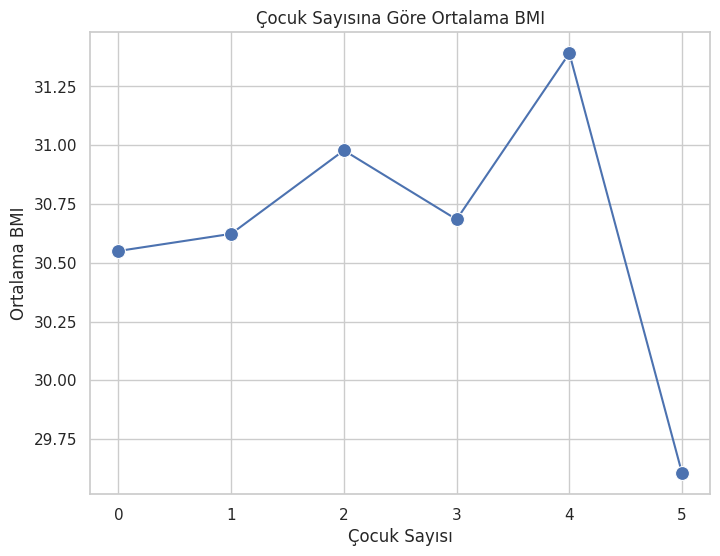

In [34]:
children_bmi=df.groupby("children")["bmi"].mean()
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")  # İsteğe bağlı: çizim stili ayarı

sns.lineplot(data=children_bmi, x=children_bmi.index, y=children_bmi, marker="o", markersize=10)

plt.title("Çocuk Sayısına Göre Ortalama BMI")
plt.xlabel("Çocuk Sayısı")
plt.ylabel("Ortalama BMI")
plt.xticks(rotation=0)
plt.show()

-> Relationship between “bmi” and “charges”:

Text(0.5, 1.0, 'Scatter Plot of BMI vs Charges')

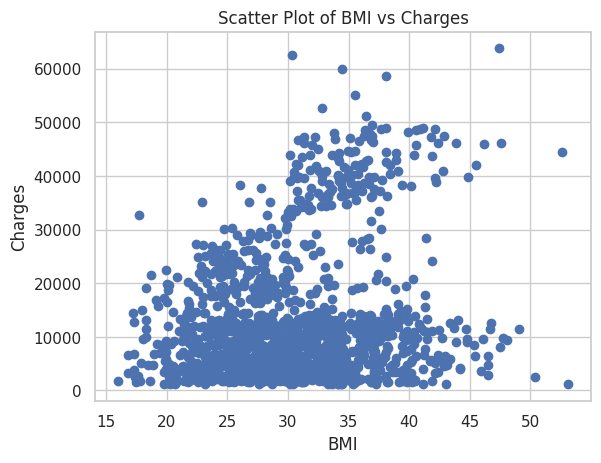

In [35]:
plt.scatter(df["bmi"],df["charges"])
plt.xlabel("BMI")
plt.ylabel("Charges")
plt.title("Scatter Plot of BMI vs Charges")

-> Relationship between "region", "smoker" and "bmi":

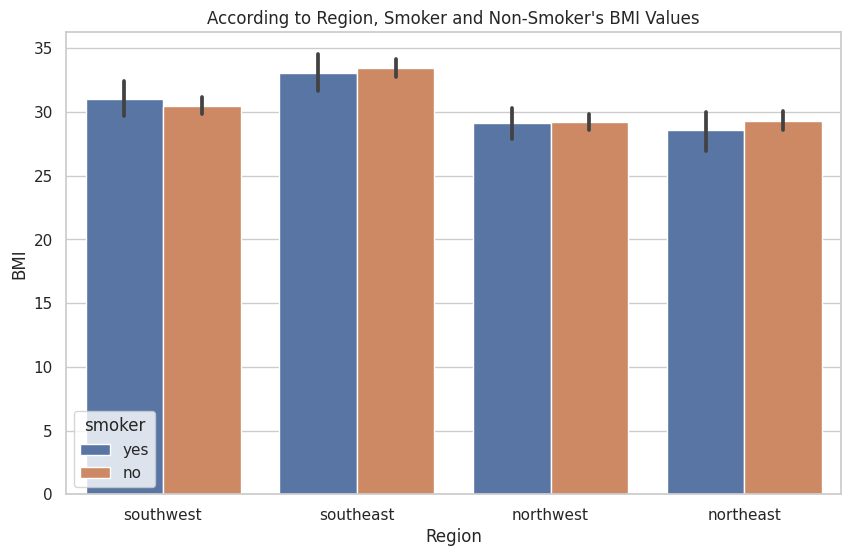

In [37]:

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")  # İsteğe bağlı: çizim stili ayarı

sns.barplot(data=df, x="region", y="bmi", hue="smoker")

plt.title("According to Region, Smoker and Non-Smoker's BMI Values")
plt.xlabel("Region")
plt.ylabel("BMI")
plt.xticks(rotation=0)
plt.show()

Looking at this graph, we can generally say the following: -Smoking or not smoking did not change the average of bmi values much. -Only in the southweast, smokers have a high BMI. -Smoking or not, the highest bmi averages are in the southeast.

DATA PREPROCESSING

---



---



Before we start modeling, we will do encoding operations.

Label Encoder

---



We will convert categorical data to numeric values.

In [38]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [39]:
binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
               and df[col].nunique() == 2]

In [40]:
binary_cols

['sex', 'smoker']

In [41]:
for col in binary_cols:
    label_encoder(df, col)

In [42]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,southwest,16884.92400
1,18,1,33.770,1,0,southeast,1725.55230
2,28,1,33.000,3,0,southeast,4449.46200
3,33,1,22.705,0,0,northwest,21984.47061
4,32,1,28.880,0,0,northwest,3866.85520


One Hot Encoder

---



In [43]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [44]:
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]

In [45]:
ohe_cols

['children', 'region']

In [46]:
df = one_hot_encoder(df, ohe_cols).head()

In [47]:
df.head()

,age,sex,bmi,smoker,charges,children_1,children_2,children_3,children_4,children_5,region_northwest,region_southeast,region_southwest
0,19,0,27.900,1,16884.92400,0,0,0,0,0,0,0,1
1,18,1,33.770,0,1725.55230,1,0,0,0,0,0,1,0
2,28,1,33.000,0,4449.46200,0,0,1,0,0,0,1,0
3,33,1,22.705,0,21984.47061,0,0,0,0,0,1,0,0
4,32,1,28.880,0,3866.85520,0,0,0,0,0,1,0,0


In [48]:
cat_cols,num_cols,cat_but_car=grab_col_names(df)

Observations: 5
Variables: 13
cat_cols: 5
num_cols: 0
cat_but_car: 0
num_but_cat: 5


In [49]:
cat_cols,num_cols,cat_but_car=grab_col_names(df)

Observations: 5
Variables: 13
cat_cols: 5
num_cols: 0
cat_but_car: 0
num_but_cat: 5


In [51]:
#We separated the dependent and independent variable.
X = df.drop("charges", axis=1)
y = df["charges"]

In [52]:
#We have separated it by specifying test_size =0.20 as train/test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Min-Max Scaling

In [53]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df.drop("charges", axis=1))
df = pd.DataFrame(X_scaled, columns=df.drop("charges", axis=1).columns)

In [54]:
df.head()

,age,sex,bmi,smoker,children_1,children_2,children_3,children_4,children_5,region_northwest,region_southeast,region_southwest
0,0.066667,0.0,0.469498,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.000000,1.0,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.666667,1.0,0.930411,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1.000000,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.933333,1.0,0.558066,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


MODELS

---



---



In [55]:
models = [
    ("Random Forest", RandomForestRegressor()),
    ('CART', DecisionTreeRegressor()),
    ('GBM', GradientBoostingRegressor()),
    ("CatBoost", CatBoostRegressor(verbose=False))
]
knn = KNeighborsClassifier(n_neighbors=3)

In [56]:
# Train models and evaluate performance
for name, regressor in models:
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=3, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 3)} ({name}) ")

RMSE: 10251.854 (Random Forest) 
RMSE: 13358.121 (CART) 
RMSE: 12225.932 (GBM) 
RMSE: 12205.733 (CatBoost) 


Hyper-parameter Optimization

---



In [57]:
from sklearn.model_selection import GridSearchCV

#Best performing model
best_model = RandomForestRegressor()

# Possible values of hyper-parameters
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10]
}

# Hyper-parameter optimization with Grid Search
grid_search = GridSearchCV(best_model, param_grid, cv=3, scoring="neg_mean_squared_error")
grid_search.fit(X, y)

print("Best Parameters:", grid_search.best_params_)
print("Best Negative MSE:", grid_search.best_score_)

Best Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 300}
Best Negative MSE: -71760617.99661168


Model Evaluation

---



---



In [ ]:
best_optimized_model = grid_search.best_estimator_

#We will make predictions using test data
y_pred = best_optimized_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f"Optimized Model MSE on Test Data: {mse}")
